In [29]:
from matplotlib import pyplot as plt
import os
import pandas as pd
import numpy as np
import math
from sklearn.metrics import accuracy_score

from utils.utils import read_label, get_label_reconstructed
from config import ExperimentConfig, get_base_path
from experiments.experiment import Experiment
from analysis.annotate_utils import read_label, get_label_reconstructed, compute_accuracy
%matplotlib inline

In [30]:
pd.set_option('display.max_columns', 400)

In [31]:
N_3 = 32
N_2 = 128
N_1 = 64
Z_DIM = 5
run_id = 2

ROOT_PATH = "/Users/sunilkumar/concept_learning_old/image_classification_old/"
exp_config = ExperimentConfig(ROOT_PATH, 4, Z_DIM, [N_1, N_2, N_3], None)
exp_config.check_and_create_directories(run_id)
BATCH_SIZE = exp_config.BATCH_SIZE
DATASET_NAME = exp_config.dataset_name
exp_config.check_and_create_directories(run_id, create=False)

SPLIT_NAME = exp_config.split_name
run_ids = [1]
if not exp_config.check_and_create_directories(run_ids, create=False):
    raise Exception("Directories does not exist")

In [32]:
MODEL_NAME ="VAE"

annotator = "SUNIL"
num_label_files = 2
NUMBER_OF_ROWS = 16
NUM_DIGITS_PER_ROW = 4
MAX_BACKUPS = 10
ANNOTATED_CSV = "annotation.csv"
last_epoch = 20
eval_interval = 300

num_label_files = 2
num_rows_per_image = 16
num_digits_per_row = 4



In [33]:
run_id = 1
accuracy_dict =dict()
max_epoch = 10
for z_dim in [1, 2, 5, 10, 20]:
    BASE_PATH = get_base_path(ROOT_PATH, z_dim, N_3, N_2,
                              exp_config.num_cluster_config,
                              version=run_id)
    PREDICTION_RESULTS_PATH = os.path.join(BASE_PATH, "prediction_results/")
    ANNOTATED_PATH = BASE_PATH + "manual_annotation"
    
    label_file = PREDICTION_RESULTS_PATH + "/label_test_{:02d}.csv"
    labels = read_label(label_file, num_label_files)

    accuracy_df = compute_accuracy(labels,
                                   ANNOTATED_PATH,
                                   max_epoch,
                                   num_label_files,
                                   num_rows_per_image,
                                   num_digits_per_row,
                                   eval_interval)
    accuracy_dict[z_dim] = [max(accuracy_df["Accuracy"].values),accuracy_df]


Invalid character in annotation,epoch 5 , step 1
('Invalid character in annotated data - ', 3)
Invalid character in annotation,epoch 2 , step 2
('Invalid character in annotated data - ', 16)
Invalid character in annotation,epoch 4 , step 1
('Invalid character in annotated data - ', 1)
Invalid character in annotation,epoch 6 , step 2
('Invalid character in annotated data - ', 11)
Invalid character in annotation,epoch 2 , step 2
('Invalid character in annotated data - ', 8)
Invalid character in annotation,epoch 0 , step 1
('Invalid character in annotated data - ', 1)
Invalid character in annotation,epoch 2 , step 2
('Invalid character in annotated data - ', 15)


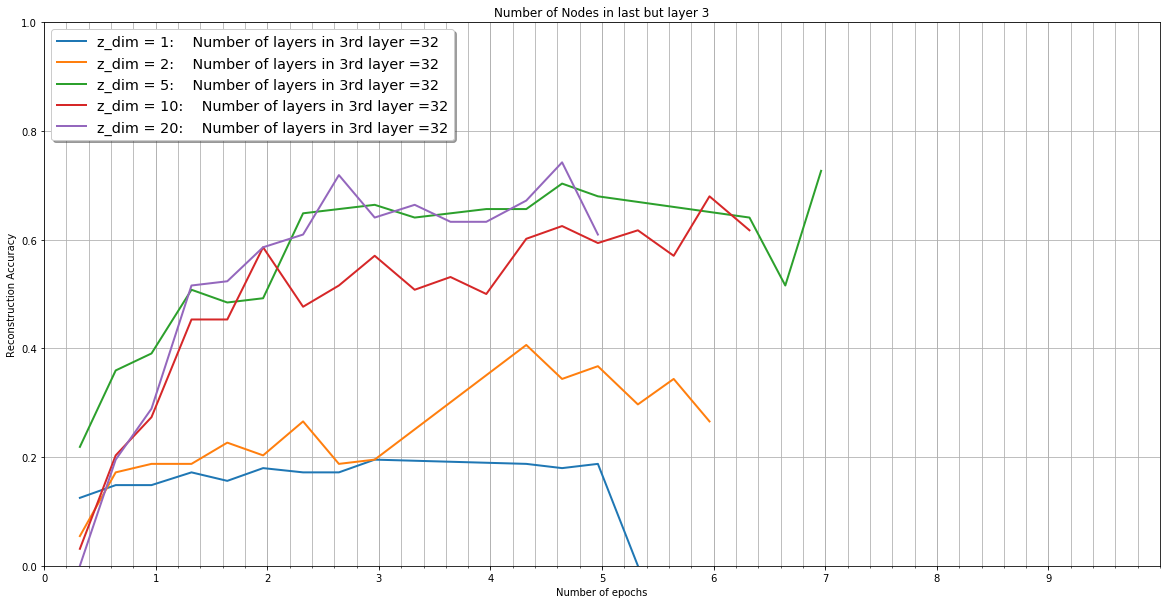

In [34]:
# TODO format the legend properly
from matplotlib.ticker import MultipleLocator
num_training_samples = 59872
steps_per_epoch = num_training_samples / BATCH_SIZE
max_steps =  max_epoch * steps_per_epoch
plt.figure(figsize=(20,10))
plot_filename = "reconstruction_accuracy.jpg"
for z_dim, result in accuracy_dict.items():
    max_accuracy = result[0]
    accuracy_df = result[1]
    x = accuracy_df["Epochs"].values
    x = x.reshape(x.shape[0])
    y = accuracy_df["Accuracy"].values
    y = y.reshape(y.shape[0])
    plt.plot(x, y, label="z_dim = {}:    Number of layers in 3rd layer ={}".format(z_dim,N_3), lw=2)
    plt.xlabel("Number of epochs")
    plt.ylabel("Reconstruction Accuracy")
plt.legend(loc='upper left', shadow=True, fontsize='x-large')
plt.xlim(0,max_epoch)
plt.xticks([i for i in range(max_epoch)])

plt.ylim(0,1)
plt.grid(which="both")
plt.axes().xaxis.set_minor_locator(MultipleLocator(0.2))
plt.title("Number of Nodes in last but layer 3".format(N_3))
plt.savefig(os.path.join(ROOT_PATH, "combined_analysis", plot_filename), bbox="tight") 
#.savefig(os.path.join(DOC_PATH, plot_filename), bbox="tight")

In [35]:
for z_dim, result in accuracy_dict.items():
    print(z_dim, max(result[1]["Accuracy"].values))

1 0.1953125
2 0.40625
5 0.7265625
10 0.6796875
20 0.7421875


In [36]:
accuracy_dict =dict()
max_epoch = 10
z_dim = 10
run_ids = [1, 2, 3, 4,5]
#run_ids =[2]
for run_id in run_ids:
    BASE_PATH = get_base_path(ROOT_PATH, z_dim ,N_3, N_2, exp_config.num_cluster_config, version=run_id)
    PREDICTION_RESULTS_PATH = os.path.join(BASE_PATH, "prediction_results/")
    ANNOTATED_PATH = BASE_PATH + "manual_annotation"
    label_file = PREDICTION_RESULTS_PATH + "/label_test_{:02d}.csv"
    labels = read_label(label_file, num_label_files)

    accuracy_df = compute_accuracy(labels,
                                   ANNOTATED_PATH,
                                   max_epoch,
                                   num_label_files,
                                   num_rows_per_image,
                                   num_digits_per_row,
                                   eval_interval)
    accuracy_dict[run_id] = [max(accuracy_df["Accuracy"].values),accuracy_df]
    

Invalid character in annotation,epoch 2 , step 2
('Invalid character in annotated data - ', 8)
Invalid character in annotation,epoch 2 , step 1
('Invalid character in annotated data - ', 1)


In [37]:
num_evaluations = accuracy_dict[run_ids[0]][1].shape[0]

1
2
3
4
5


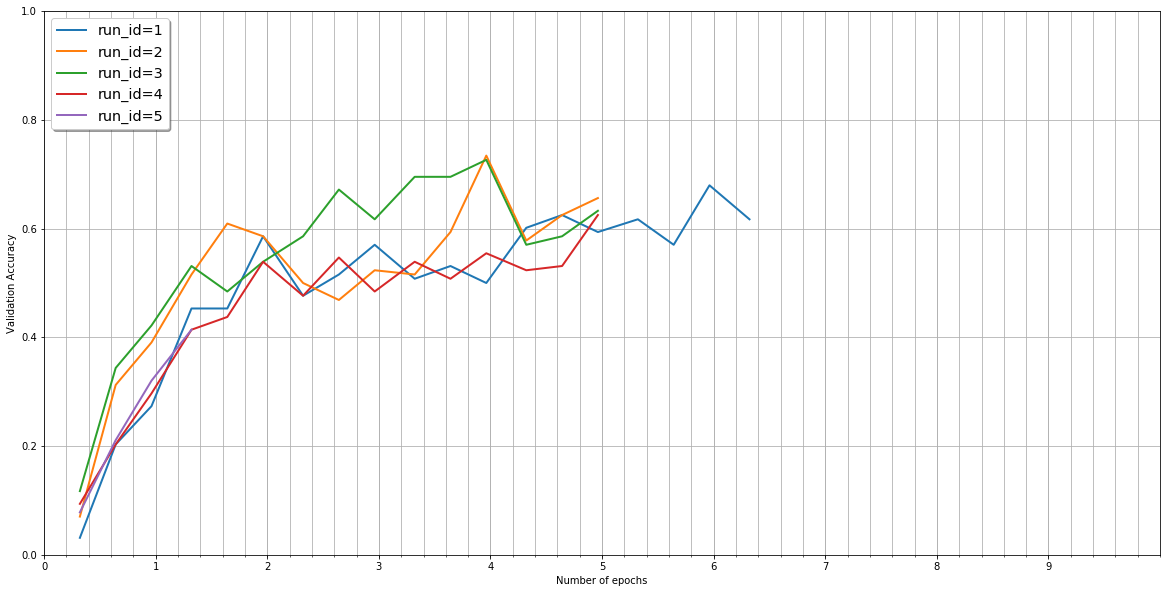

In [38]:
plt.figure(figsize=(20,10))
plot_filename = "reconstruction_accuracy_different_runs.jpg"
total = np.zeros(num_evaluations)
for run_id, result in accuracy_dict.items():
    max_accuracy = result[0]
    accuracy_df = result[1]
    x = accuracy_df["Epochs"].values
    x = x.reshape(x.shape[0])
    y = accuracy_df["Accuracy"].values
    y = y.reshape(y.shape[0])

    plt.plot(x,y,label="run_id={}".format(run_id),lw=2)
    plt.xlabel("Number of epochs")
    plt.ylabel("Validation Accuracy")
    print(run_id)
    #total = total + y
#average = total / len(run_ids)
#plt.plot(x, average,label = "Average")

plt.legend(loc='upper left', shadow=True, fontsize='x-large')
plt.xticks([i for i in range(10)])
plt.xlim(0,max_epoch)
plt.ylim(0,1)
plt.grid(which="both")
plt.axes().xaxis.set_minor_locator(MultipleLocator(0.2))
plt.savefig(os.path.join(ROOT_PATH,"combined_analysis",plot_filename),bbox="tight") 
#plt.savefig(os.path.join(DOC_PATH,plot_filename), bbox="tight")

In [11]:
print( ANNOTATED_PATH)

/Users/sunilkumar/concept_learning_old/image_classification_old/Exp_05_032_128_2/manual_annotation


In [12]:
x

array([0.32085561, 0.64171123, 0.96256684, 1.32085561, 1.64171123,
       1.96256684, 2.32085561, 2.64171123, 2.96256684, 3.32085561,
       3.64171123, 3.96256684, 4.32085561, 4.64171123, 4.96256684,
       6.32085561, 6.64171123, 6.96256684, 7.32085561, 7.64171123])

In [13]:
y

array([0.078125  , 0.2109375 , 0.2890625 , 0.453125  , 0.4453125 ,
       0.515625  , 0.53125   , 0.578125  , 0.5       , 0.5546875 ,
       0.5546875 , 0.7421875 , 0.703125  , 0.6328125 , 0.59375   ,
       0.671875  , 0.640625  , 0.6328125 , 0.6328125 , 0.60294118])

In [14]:
print(max(average))

NameError: name 'average' is not defined

In [ ]:
for run_id, result in accuracy_dict.items():
    accuracy = result[1]["Accuracy"].values
    max_index = np.argmax(accuracy)
    print(run_id, result[1]["Total_Batches_Finished"].values[max_index], 
          result[1]["Epochs"].values[max_index],
          max(accuracy), max_index)